# Unsupervised Learning: Clustering Lab





In [792]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg as la
import numpy.ma as ma
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---

In [605]:
class HACClustering(BaseEstimator, ClusterMixin):

    def __init__(self, k=3, link_type="single"):  # add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.k = k
        self.link_type = link_type
        
    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # Setup distance matrix and clusters
        A = np.array([la.norm(X - val, axis=1) for val in X])
        self.clusters = dict(enumerate([[val] for val in X]))
        
        # Setup optimization metrics
        opt = np.min if self.link_type == "single" else np.max
        
        while len(self.clusters) > self.k:
            mask = np.diag(np.ones(len(A)))
            x, y = np.unravel_index(np.argmin(ma.MaskedArray(A, mask)), A.shape)
            if x == y:
                print(ma.MaskedArray(A, A==0))

            dists = opt(list(zip(A[x], A[y])), axis=1)
            dists[x] = 0

            A[x] = dists
            A[:,x] = dists
            A = np.delete(A, y, axis=0)
            A = np.delete(A, y, axis=1)
            
            self.clusters[x] += self.clusters[y]

            self.clusters = dict(enumerate([cluster for key, cluster 
                                       in self.clusters.items() if key != y]))
        
        # Order the data and setup the labels
        self.X = self.flatten(self.clusters.values())
        keys = [np.full(len(vals), key) for key, vals in self.clusters.items()]
        self.labels = self.flatten(keys)

        return self

    def flatten(self, metalist):
        return np.array([val for sublist in metalist for val in sublist])
    
    def silhouette(self):
        return silhouette_score(self.X, self.labels)
    
    def cluster_sizes(self):
        print(*[len(cluster) for cluster in self.clusters.values()])
    
    def print_clusters(self):
        print("Num clusters: {:d}\n".format(self.k))
        print("Silhouette score: {:.4f}\n\n".format(self.silhouette()))
        for cluster in self.clusters.values():
            centroid = np.mean(np.array(cluster), axis=0)
            print(np.array2string(centroid,precision=4,separator=","))
            print("{:d}\n".format(len(cluster)))

### 1.1.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.


- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.


---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link%20(Silhouette).txt)

[Debug HAC Complete (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link%20(Silhouette).txt)

In [557]:
# Debug Here
# Load data
abalone = arff.loadarff("datasets/abalone.arff")
abalone_np = np.array(abalone[0].tolist())
abalone_scaled_np = MinMaxScaler().fit_transform(abalone_np)

# Single link
hac = HACClustering(5, link_type="single")
hac.fit(abalone_scaled_np).print_clusters()

# Complete link
hac = HACClustering(5, link_type="complete")
hac.fit(abalone_scaled_np).print_clusters()

Num clusters: 5

Silhouette score: 0.3453


[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1

Num clusters: 5

Silhouette score: 0.3095


[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71

[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67

[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38

[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16

[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8



### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

#### 1.1.3.1 Complete Link

In [501]:
# Load evaluation data
seismic = arff.loadarff("datasets/seismic-bumps_train.arff")
seismic_np = np.array(seismic[0].tolist())
seismic_scaled_np = MinMaxScaler().fit_transform(seismic_np)

# Train on evaluation data using complete link
hac = HACClustering(5, link_type="complete")
hac.fit(seismic_scaled_np)

# Print clusters
hac.print_clusters()

Num clusters: 5

Silhouette score: 0.2930


[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49

[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3

[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18

[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49

[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21



#### 1.1.3.1 Single Link

In [249]:
# Load evaluation data

# Train on evaluation data using single link
hac = HACClustering(5, link_type="single")
hac.fit(seismic_scaled_np)

# Print clusters
hac.print_clusters()

Num clusters: 5

Silhouette score: 0.3971


[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70



### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---
You only need to handle continuous features

In [654]:
class KMEANSClustering(BaseEstimator, ClusterMixin):

    def __init__(self, k=3, debug=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug

    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # Create initial centroids
        initial = X[:self.k] if self.debug else np.random.random((self.k, len(X[0])))
        self.centroids = dict(enumerate(initial))

        max_iter = 2500
        tol = 1e-4
        for i in range(max_iter):
            
            # Compute clusters
            dists = np.array([la.norm(list(self.centroids.values()) - val, axis=1)
                          for val in X])
            mins = np.argmin(dists, axis=1)
            self.clusters = {j: [] for j in range(self.k)}
            for j, val in enumerate(X):
                self.clusters[mins[j]].append(val)
            
            # Recompute centroids
            prev = dict(self.centroids)            
    
            for j, cluster in self.clusters.items():
                if len(cluster) > 0:
                    self.centroids[j] = np.mean(cluster, axis=0)
                else:
                    self.centroids[j] = np.random.random(len(X[0]))
            
            # See if the centroids have moved much
            converged = True
            for centroid in self.centroids:
                if la.norm(prev[centroid] - self.centroids[centroid]) > tol:
                    converged = False
                    break
            
            if converged:
                break
        
        self.X = self.flatten(self.clusters.values())
        keys = [np.full(len(vals), key) for key, vals in self.clusters.items()]
        self.labels = self.flatten(keys)
        
        return self
    
    def flatten(self, metalist):
        return np.array([val for sublist in metalist for val in sublist])

    def silhouette(self):
        return silhouette_score(self.X, self.labels)
    
    def cluster_sizes(self):
        print(*[len(cluster) for cluster in self.clusters.values()])
    
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}\n".format(self.k))
        print("Silhouette score: {:.4f}\n\n".format(silhouette_score(self.X, self.labels)))
        for cluster in self.clusters.values():
            centroid = np.mean(np.array(cluster), axis=0)
            print(np.array2string(centroid,precision=4,separator=","))
            print("{:d}\n".format(len(cluster)))

In [641]:
print(type(np.nan) is np.ndarray)

d = {1: 2, 3: 4}
d = {i: d[i] for i in [1, 3]}
d

False


{1: 2, 3: 4}

### 1.2.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values




---
Solutions in files:

[Debug K Means (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means%20(Silhouette).txt)

In [655]:
# Load debug data

# Train on debug data
kmeans = KMEANSClustering(5, debug=True)
kmeans.fit(abalone_scaled_np)

# Print clusters
kmeans.print_clusters()

Num clusters: 5

Silhouette score: 0.3845


[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13



### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)
- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

In [656]:
# Load evaluation data

# Train on evaluation data
kmeans = KMEANSClustering(5, debug=True)
kmeans.fit(seismic_scaled_np)

# Print clusters
kmeans.print_clusters()

Num clusters: 5

Silhouette score: 0.2769


[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20

[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48



## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

50 100
49 1 100
49 1 98 2
49 1 97 1 2
49 1 96 1 1 2
49 1 95 1 1 1 2


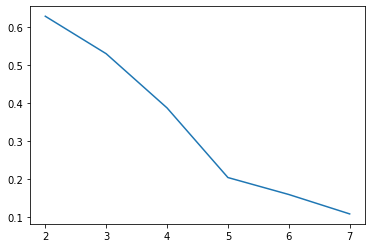

In [581]:
# Iris Classification using single-link
iris = arff.loadarff("datasets/iris.arff")

# Encode classes
iris_df = pd.DataFrame(iris[0])
iris_df["class"] = LabelEncoder().fit_transform(iris_df["class"])
iris_np = iris_df.to_numpy()

# Normalize the data
iris_scaled_np = MinMaxScaler().fit_transform(iris_np)

dom = np.arange(2, 8)
scores = []
for k in dom:
    hac = HACClustering(k, link_type="single")
    hac.fit(iris_scaled_np[:,:-1])
    scores.append(hac.silhouette())
    hac.cluster_sizes()
plt.plot(dom, scores)
plt.show()

116 34
50 66 34
33 17 66 34
33 17 37 29 34
33 17 37 29 23 11
33 17 23 29 14 23 11


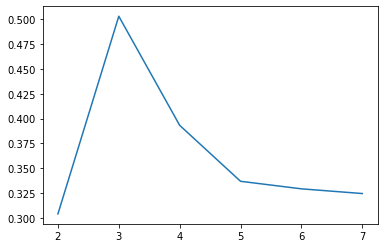

In [582]:
# Iris Classification using complete-link
scores = []
for k in dom:
    hac = HACClustering(k, link_type="complete")
    hac.fit(iris_scaled_np[:,:-1])
    scores.append(hac.silhouette())
    hac.cluster_sizes()
plt.plot(dom, scores)
plt.show()

I normalized the data. Single link as a higher max accuracy in this case where we didn't include the classes. The shapes of the graphs are really different too, the complete link does worst at k=2 while single link does best here. The single link can really only make 2 bit clusters while the complete link can break into about evenly sized clusters for each k.

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

50 100
50 50 50
50 50 49 1
49 1 50 49 1
49 1 50 47 1 2
49 1 50 46 1 2 1


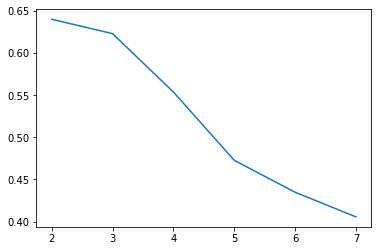

In [585]:
# Clustering Labels using single-link
scores = []
for k in dom:
    hac = HACClustering(k, link_type="single")
    hac.fit(iris_scaled_np)
    scores.append(hac.silhouette())
    hac.cluster_sizes()
plt.plot(dom, scores)
plt.show()

50 100
50 70 30
33 17 70 30
33 17 50 30 20
33 17 21 29 30 20
33 17 21 29 19 20 11


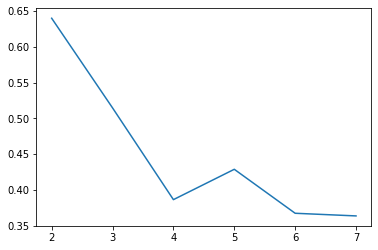

In [586]:
# Clustering Labels using complete-link
scores = []
for k in dom:
    hac = HACClustering(k, link_type="complete")
    hac.fit(iris_scaled_np)
    scores.append(hac.silhouette())
    hac.cluster_sizes()
plt.plot(dom, scores)
plt.show()

Both did better with the classes included. The biggest difference can be seen in the complete link graph. It now peaks at k=2 just like single link and basically goes do from there. Single link made more evenly distributed cluster sized at least for k=3.

## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

100 50
61 39 50
31 42 50 27
35 43 15 30 27
44 26 25 20 11 24
25 25 12 36 21 14 17


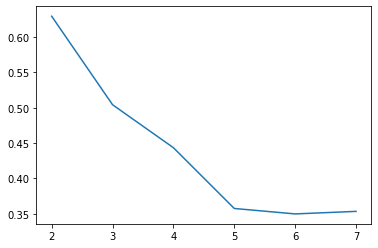

In [669]:
# Iris Classification without output label
scores = []
for k in dom:
    kmeans = KMEANSClustering(k)
    kmeans.fit(iris_scaled_np[:,:-1])
    scores.append(kmeans.silhouette())
    kmeans.cluster_sizes()
plt.plot(dom, scores)
plt.show()

50 100
50 50 50
23 27 50 50
21 50 27 23 29
26 23 27 23 24 27
4 24 21 28 22 29 22


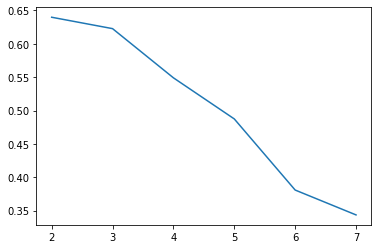

In [682]:
# Iris Classification with output label
scores = []
for k in dom:
    kmeans = KMEANSClustering(k)
    kmeans.fit(iris_scaled_np)
    scores.append(kmeans.silhouette())
    kmeans.cluster_sizes()
plt.plot(dom, scores)
plt.show()

They both have similar shapes to the graph but the best score is a bit higher with the class. It looks like it did a really good job seperating the data into evenly sized clusters.

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

23 50 27 50
24 50 26 50
27 49 50 24
50 50 27 23
15 35 50 50


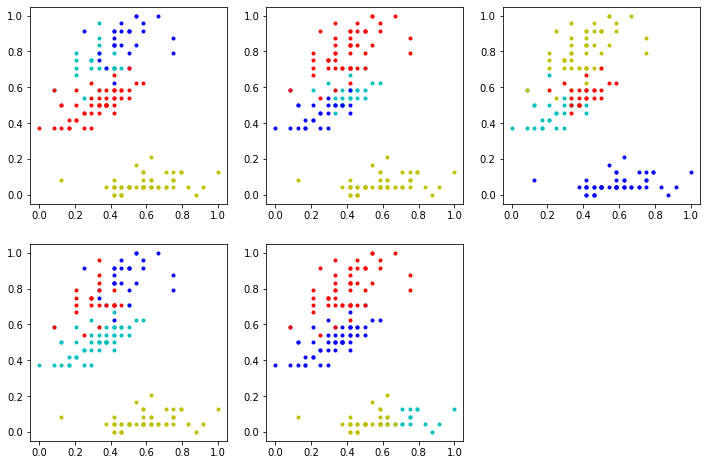

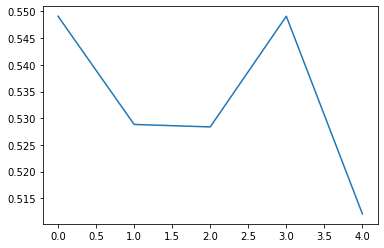

In [808]:
# K-Means 5 times
scores = []
plt.figure(figsize=(12, 8))
colors = ["c.", "y.", "b.", "r."]
for i in range(5):
    plt.subplot(2, 3, i+1)
    kmeans = KMEANSClustering(4)
    kmeans.fit(iris_scaled_np)
    
    for j, X in kmeans.clusters.items():
#         pca = PCA(n_components=2)
#         x, y = pca.fit_transform(X).T
        x, y = np.array(X)[:,[1, 3]].T
        plt.gca().set_aspect("equal")
        plt.plot(x, y, colors[j])
    
    scores.append(kmeans.silhouette())
    kmeans.cluster_sizes()
plt.show()
plt.plot(scores)
plt.show()

I plotted a few of the dimentions of the data and how they got clustered. As you can see they can vary quite a bit. The score varied as well.

## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

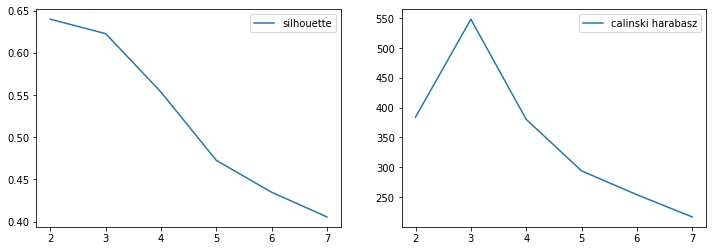

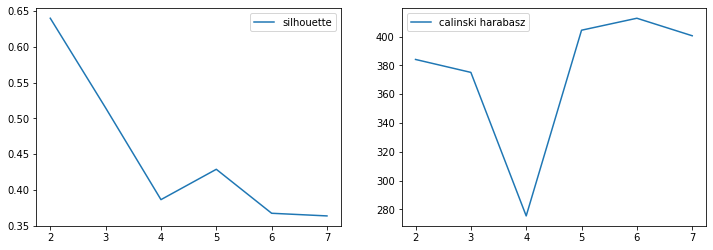

0.6398447268887528
0.47886050421178256


In [795]:
# Load sklearn
sil, cal = [], []
for k in dom:
    hac = AgglomerativeClustering(n_clusters=k, linkage="single")
    y = hac.fit_predict(iris_scaled_np)
    sil.append(silhouette_score(iris_scaled_np, y))
    cal.append(calinski_harabasz_score(iris_scaled_np, y))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dom, sil, label="silhouette")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(dom, cal, label="calinski harabasz")
plt.legend()
plt.show()

# Clustering Labels using complete-link
sil, cal = [], []
for k in dom:
    hac = AgglomerativeClustering(n_clusters=k, linkage="complete")
    y = hac.fit_predict(iris_scaled_np)
    sil.append(silhouette_score(iris_scaled_np, y))
    cal.append(calinski_harabasz_score(iris_scaled_np, y))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dom, sil, label="silhouette")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(dom, cal, label="calinski harabasz")
plt.legend()
plt.show()

hac = AgglomerativeClustering(n_clusters=2, affinity="cosine", linkage="average")
y = hac.fit_predict(iris_scaled_np)
print(silhouette_score(iris_scaled_np, y))
hac = AgglomerativeClustering(n_clusters=2, affinity="l1", linkage="complete")
y = hac.fit_predict(iris_scaled_np)
print(silhouette_score(iris_scaled_np, y))

I did not use my own silhouette scoring function. Silhouette worked really well for choosing the best clustering. I used the calinski harabasz metric. After trying out a couple different hyperparameters, it seems an l2 distance function does quite a bit worse than the others.

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

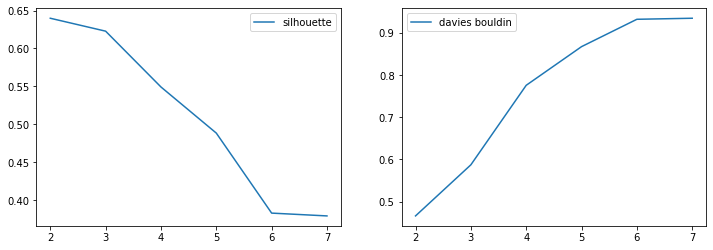

0.6398447268887528
0.6398447268887528


In [804]:
# Load sklearn 
sil, dav = [], []
for k in dom:
    kmeans = KMeans(n_clusters=k)
    y = kmeans.fit_predict(iris_scaled_np)
    sil.append(silhouette_score(iris_scaled_np, y))
    dav.append(davies_bouldin_score(iris_scaled_np, y))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dom, sil, label="silhouette")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(dom, dav, label="davies bouldin")
plt.legend()
plt.show()


kmeans = KMeans(n_clusters=2, init="random", n_init=1)
y = kmeans.fit_predict(iris_scaled_np)
print(silhouette_score(iris_scaled_np, y))
kmeans = KMeans(n_clusters=2, init="random", n_init=100)
y = kmeans.fit_predict(iris_scaled_np)
print(silhouette_score(iris_scaled_np, y))

I did not use my own silhouette scoring function. The silhouette function is really good at choosing the best k to choose. From the plots of the points above, you can see that the worse clusterings have lower silhouette scores. I tried out using the davies bouldin scoring function. I tried haveing the algorithm initialize random centroids once and then 100 times and it didn't chnage the silhouette score which was unexpected.

## 4. (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version. 


*Show findings here*

In [ ]:
# Copy function Below